In [2]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mapping import map_str_values
import mapping
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Xử lý dữ liệu

## Đọc dữ liệu và chuyển biến phân loại dạng string về int

In [3]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
X = map_str_values(X)
# X = remove_categorical_vars(X)
X

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,1,2,0,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,2,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
669485,17,715,2060,2,0,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
602512,17,51,8163,3,55,6,7,2,2,1,...,0,0,0,0,0,0,0,0,0,0


Đọc file labels và chuyển convert damage_grade thành đúng định dạng 0 1 2

In [4]:
Y = pd.read_csv("data/train_labels.csv", index_col="building_id")
temp = {
    1: 0,
    2: 1,
    3: 2
}

Y["damage_grade"] = Y["damage_grade"].map(temp)

## Áp dụng min max scaler cho data

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## Chia train test trực tiếp từ bộ train_values và train_labels

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size=0.25, random_state=192)
np.unique(Y_train)

array([0, 1, 2], dtype=int64)

---

# Model

In [ ]:
class GaussianNBClassifier:
    def __init__(self):
        pass
    
    def separate_classes(self, X, y):
        separated_classes = {}
        for i in range(len(X)):
            feature_values = X[i]
            class_name = y.iloc[i]['damage_grade']
            if class_name not in separated_classes:
                separated_classes[class_name] = []
            separated_classes[class_name].append(feature_values)
        return separated_classes
    
    def summarize(self, X):
        for feature in zip(*X):
            yield {
                'stdev' : np.std(feature),
                'mean' : np.mean(feature)
            }

    def gauss_distribution_function(self, x, mean, stdev):
        exponent = np.exp(-((x-mean)**2 / (2*stdev**2)))
        return exponent / (np.sqrt(2*np.pi)*stdev)
    
    def fit(self, X, y):
        separated_classes = self.separate_classes(X, y)
        self.class_summary = {}
        for class_name, feature_values in separated_classes.items():
            self.class_summary[class_name] = {
                'prior_proba': len(feature_values)/len(X),
                'summary': [i for i in self.summarize(feature_values)],
            }     
        return self.class_summary
    
    def predict_proba(self, X):
        predictions = []
        for row in X:
            joint_proba = {}
            for class_name, features in self.class_summary.items():
                total_features = len(features['summary'])
                likelihood = 1
                for idx in range(total_features):
                    feature = row[idx]
                    mean = features['summary'][idx]['mean']
                    stdev = features['summary'][idx]['stdev']
                    normal_proba = self.gauss_distribution_function(feature, mean, stdev)
                    likelihood *= normal_proba
                prior_proba = features['prior_proba']
                joint_proba[class_name] = prior_proba * likelihood
            predictions.append(joint_proba)
        return predictions

    def predict(self, X):
        predictions = self.predict_proba(X)
        MAPs = []
        for joint_proba in predictions:
            MAP = max(joint_proba, key=joint_proba.get)
            MAPs.append(MAP)
        return MAPs

## Multinomial NB

Công thức xác xuất của label c phụ thuộc vào các biến dự đoán:

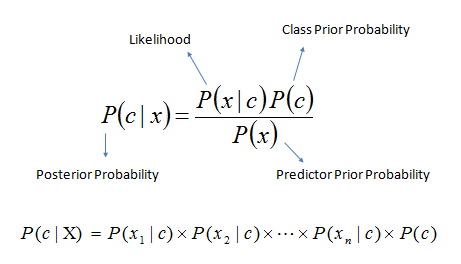

Trong đó ở multinomial NB thì (Px|c) được tính như sau:

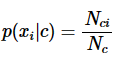

Từ các xác xuất tính được của mỗi class phụ thuộc vào biến dự đoán, class c được xác định và phân loại bởi xác xuất lớn nhất trong số các xác xuất tính được

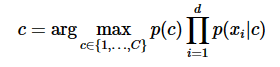

In [24]:
class MultinomialNBHandMade():
    def __init__(self, alpha=1.0, likelihoods=None, class_priors=None):
        self.alpha = alpha # Tham số alpha để thực hiện Laplace smoothing
        self.class_priors = class_priors # mảng lưu trữ các xác suất của các class
        self.likelihoods = likelihoods # Mảng lưu trữ trọng số của các feature ứng với mỗi class

    def _check_negative(self, X):
        if (X[X < 0].shape[0] > 0):
            # print(X)
            raise Exception("No negative ples!")

    def fit(self, X, y): 
        self._check_negative(X)
        self._update_probs(X, y)


    def _update_probs(self, X, y): # Cập nhật trọng số theo công thức
        self.classes = np.unique(y) # Lấy ra giá trị các class
        n_classes = len(self.classes)
        n_features = X.shape[1]

        self.class_priors = np.empty(shape=(n_classes))
        self.likelihoods = np.empty(shape=(n_classes, n_features))

        for i, label in enumerate(self.classes):
            Xc = X[np.where(y == label)] # Lấy ra tất cả các records với class = label

            self.class_priors[i] = (len(Xc) + self.alpha) / (len(X) + self.alpha * n_classes) # P(c)
            self.likelihoods[i] = (np.sum(Xc, axis=0) + self.alpha) / (np.sum(Xc) + self.alpha * n_features) # P(Xi|c)
            print(self.likelihoods[i].shape)

    
    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for i in range(len(self.classes)):
                posterior = np.log(self.class_priors[i]) + np.sum(np.log(self.likelihoods[i]) * x) # Tính P(C|x)
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)]) # max(P(C|Xi))
        return np.array(y_pred)


mnb = MultinomialNBHandMade()

In [25]:
mnb.fit(X_train, Y_train["damage_grade"])

(38,)
(38,)
(38,)


In [23]:
print(mnb.likelihoods)

[[7.46416953e-02 5.90747351e-02 6.44251583e-02 1.35557237e-02
  2.25242261e-03 1.13211703e-02 1.35148842e-02 1.14147338e-01
  7.20068678e-02 4.90689133e-02 3.53027183e-02 4.88863908e-02
  8.61004627e-02 3.41005410e-02 3.10744688e-03 4.52770068e-02
  1.02668950e-03 4.21627153e-03 3.21011583e-03 3.62216054e-02
  3.96165254e-02 1.46405922e-02 1.97261275e-02 1.33743418e-02
  3.38123074e-03 8.06977944e-02 1.31355415e-02 2.18068849e-02
  4.27787290e-03 1.13551858e-02 4.49689999e-03 5.13344748e-04
  1.64270319e-04 3.21696042e-04 8.21351597e-05 8.21351597e-05
  2.73783866e-05 8.41885387e-04]
 [6.11474820e-02 6.71824756e-02 6.79966284e-02 1.94063586e-02
  3.77921912e-03 9.74817705e-03 1.56963464e-02 1.15306652e-01
  7.36537540e-02 2.28870635e-02 1.66397158e-02 5.58976789e-02
  9.32023482e-02 3.37226520e-02 1.29229472e-02 1.05505679e-01
  4.24296840e-03 2.97119022e-03 1.07168013e-02 1.05684890e-02
  3.71942590e-02 1.29550815e-02 5.37384987e-03 1.32368749e-03
  2.08626002e-03 8.97952845e-02 1.497

              precision    recall  f1-score   support

           0       0.50      0.33      0.40      6275
           1       0.58      0.94      0.72     37165
           2       0.56      0.02      0.03     21711

    accuracy                           0.57     65151
   macro avg       0.55      0.43      0.38     65151
weighted avg       0.57      0.57      0.46     65151



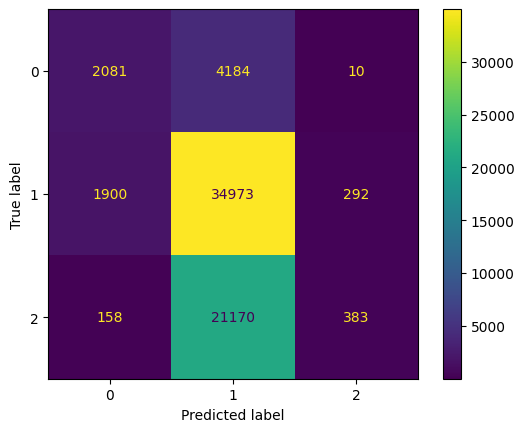

In [10]:
Y_pred = mnb.predict(X_test.astype(int))
cm = metrics.confusion_matrix(Y_test, Y_pred)
print(metrics.classification_report(Y_test, Y_pred))
metrics.ConfusionMatrixDisplay(cm).plot()

## Gaussian Naive Bayes

In [12]:
gaussNB = GaussianNB()
gaussNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

- Predict

In [13]:
Y_pred = gaussNB.predict(X_test)
Y_pred

array([0, 2, 1, ..., 2, 1, 0], dtype=int64)

- Ma trận bối rối

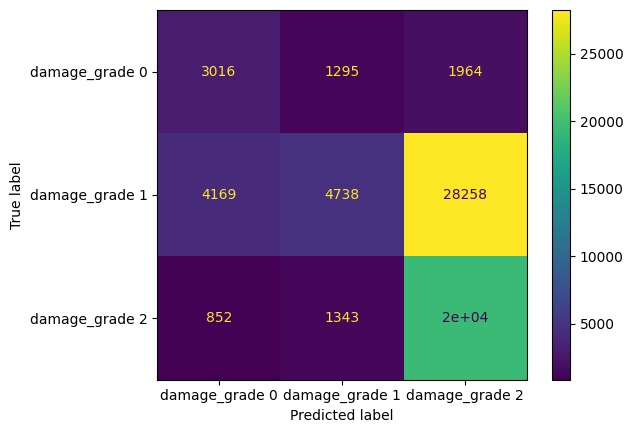

In [14]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot()

- So sánh Số liệu của kết quả 

In [15]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.38      0.48      0.42      6275
damage_grade 1       0.64      0.13      0.21     37165
damage_grade 2       0.39      0.90      0.55     21711

      accuracy                           0.42     65151
     macro avg       0.47      0.50      0.39     65151
  weighted avg       0.53      0.42      0.34     65151



## Bernouli Naive Bayes

In [16]:
bernNB = BernoulliNB()
bernNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB()

In [17]:
Y_pred = bernNB.predict(X_test)
Y_pred

array([0, 2, 1, ..., 2, 0, 0], dtype=int64)

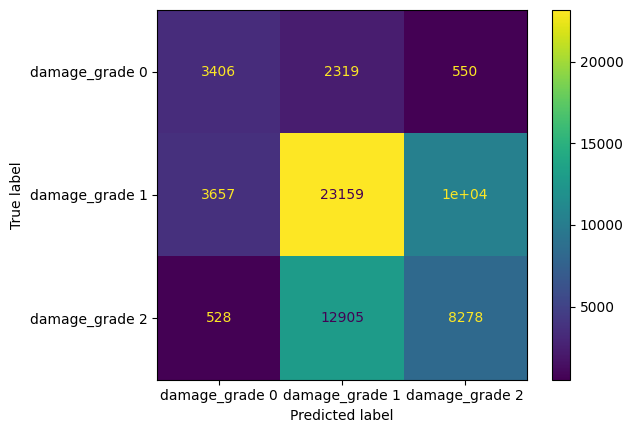

In [18]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot()

In [19]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.45      0.54      0.49      6275
damage_grade 1       0.60      0.62      0.61     37165
damage_grade 2       0.43      0.38      0.40     21711

      accuracy                           0.53     65151
     macro avg       0.49      0.52      0.50     65151
  weighted avg       0.53      0.53      0.53     65151

